# KGTopologyToolbox walk-through

<em>Copyright (c) 2024 Graphcore Ltd. All rights reserved.</em>

In this notebook we give a general overview of the classes and methods included in the `kg-topology-toolbox` library and explain how to use them to extract topological data from any knowledge graph. As an example, we use the open-source biomedical dataset [ogbl-biokg](https://ogb.stanford.edu/docs/linkprop/#ogbl-biokg).

## Dependencies

In [1]:
import sys
!{sys.executable} -m pip uninstall -y kg_topology_toolbox
!pip install -q git+https://github.com/graphcore-research/kg-topology-toolbox.git@refactor_kgtt --no-cache-dir
!pip install -q jupyter ipywidgets ogb seaborn

Found existing installation: kg-topology-toolbox 0.1.0
Uninstalling kg-topology-toolbox-0.1.0:
  Successfully uninstalled kg-topology-toolbox-0.1.0


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import ogb.linkproppred
from kg_topology_toolbox import KGTopologyToolbox

dataset_directory = "../../../data/ogb-biokg/"

## Data preparation

We load the OGBL-BioKG dataset using the `ogb.linkproppred.LinkPropPredDataset` class and store all (h, r, t) triples in a `pandas` DataFrame.

In [3]:
dataset = ogb.linkproppred.LinkPropPredDataset(
    name="ogbl-biokg", root=dataset_directory
)

all_triples = []
for split in dataset.get_edge_split().values():
    all_triples.append(np.stack([split["head"], split["relation"], split["tail"]]).T)
biokg_df = pd.DataFrame(
    np.concatenate(all_triples).astype(np.int32), columns=["h", "r", "t"]
)
biokg_df

,h,r,t
0,1718,0,3207
1,4903,0,13662
2,5480,0,15999
3,3148,0,7247
4,10300,0,16202
...,...,...,...
5088429,2451,50,5097
5088430,6456,50,8833
5088431,9484,50,15873
5088432,6365,50,496


Based on this representation of the knowledge graph, we can proceed to instantiate the `KGTopologyToolbox` class to compute topological properties.

In [4]:
kgtt = KGTopologyToolbox(biokg_df)

/nethome/albertoc/research/knowledge_graphs/kg-topology-toolbox/.venv/lib/python3.10/site-packages/kg_topology_toolbox/topology_toolbox.py:64: UserWarning: The Knowledge Graph contains duplicated edges -- some functionalities may produce incorrect results
  warnings.warn(


Notice the warning raised by the constructor, which detects duplicated edges in the `biokg_df` DataFrame: to ensure optimal functionalities, duplicated edges should be removed before instantiating the `KGTopologyToolbox` class.

## Node-level analysis

The method `node_degree_summary` provides a summary of the degrees of each individual node in the knowledge graph. The returned dataframe is indexed on the node ID.

- `h_degree` is the number of edges coming out from the node;
- `t_degree` is the number of edges going into the node;
- `tot_degree` is the number of edges that use the node as either head or tail;
- `h_unique_rel` (resp., `t_unique_rel`) is the number of unique relation types that come out from (resp., go into) the node;
- `n_loops` is the number of loop edges around the node.

In [5]:
node_ds = kgtt.node_degree_summary()
node_ds

,h_degree,t_degree,tot_degree,h_unique_rel,t_unique_rel,n_loops
0,27,72,99,4,4,0
1,14,94,108,3,6,0
2,208,95,303,5,7,0
3,28999,26154,55153,10,11,0
4,362,302,664,11,12,0
...,...,...,...,...,...,...
45080,21,22,43,1,1,0
45081,29,32,61,1,1,0
45082,28,30,58,1,1,0
45083,17,19,36,1,1,0


/nethome/albertoc/research/knowledge_graphs/kg-topology-toolbox/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


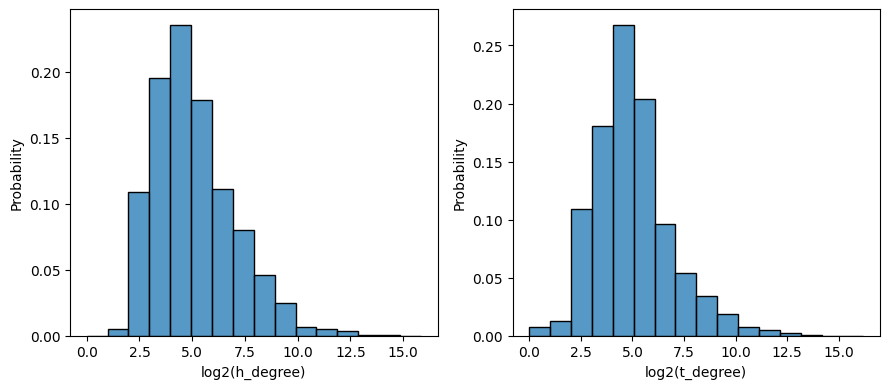

In [6]:
metrics = [
    "h_degree",
    "t_degree",
]
fig, ax = plt.subplots(1, len(metrics), figsize=(4.5 * len(metrics), 4))

for i, metric in enumerate(metrics):
    x = np.log2(node_ds[metric])
    sns.histplot(
        x=x, stat="probability", binwidth=1, binrange=[0, x.max() + 1], ax=ax[i]
    )
    ax[i].set_xlabel(f"log2({metric})")
plt.tight_layout()

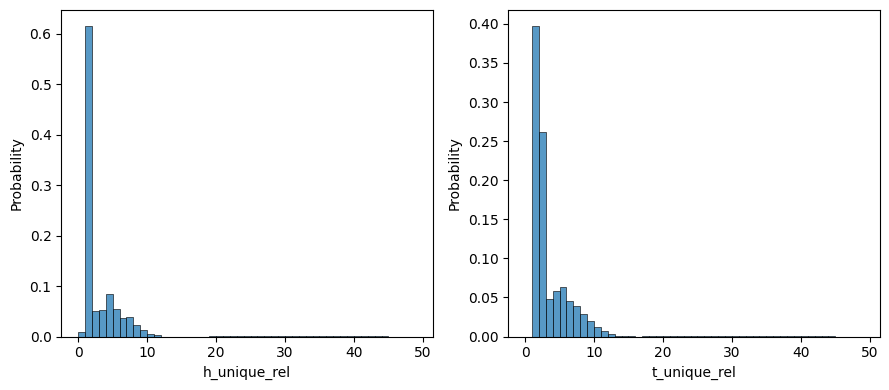

In [7]:
metrics = [
    "h_unique_rel",
    "t_unique_rel",
]
fig, ax = plt.subplots(1, len(metrics), figsize=(4.5 * len(metrics), 4))

for i, metric in enumerate(metrics):
    x = node_ds[metric]
    sns.histplot(
        x=x, stat="probability", binwidth=1, binrange=[0, x.max() + 1], ax=ax[i]
    )
    ax[i].set_xlabel(f"{metric}")
plt.tight_layout()

## Edge-level analysis

### Edge degrees and cardinality

The method `edge_degree_cardinality_summary` provides, for each edge (h, r, t) in the KG, detailed information on the connectivity patterns of the head and tail nodes:

- `h_unique_rel` (resp. `t_unique_rel`) is the number of unique relation types coming out of the head node (resp. going into the tail node);
- `h_degree` is the out-degree of the head node and `h_degree_same_rel` is the degree when only considering edges of the same relation type `r`;
- `t_degree` is the in-degree of the tail node and `t_degree_same_rel` is the degree when only considering edges of the same relation type `r`;
- `tot_degree` is the total number of edges with either head entity `h` or tail entity `t` (in particular, `tot_degree <= h_degree + t_degree`); `tot_degree_same_rel` is computed only considering edges of the same relation type `r`;
- `triple_cardinality` is the cardinality type of the edge:
    - _one-to-one_ (1:1) if `h_degree = 1`, `t_degree = 1`;
    - _one-to-many_ (1:M) if `h_degree > 1`, `t_degree = 1`;
    - _many-to-one_ (M:1) if `h_degree = 1`, `t_degree > 1`;
    - _many-to-many_ (M:M) if `h_degree > 1`, `t_degree > 1`.
- `triple_cardinality_same_rel` is defined as `triple_cardinality` but using `h_degree_same_rel`, `t_degree_same_rel`.


In [8]:
edge_dcs = kgtt.edge_degree_cardinality_summary()
edge_dcs

,h,r,t,h_degree,h_unique_rel,h_degree_same_rel,t_degree,t_unique_rel,t_degree_same_rel,tot_degree,tot_degree_same_rel,triple_cardinality,triple_cardinality_same_rel
0,1718,0,3207,191,5,116,46,6,14,236,129,M:M,M:M
1,4903,0,13662,544,8,33,1975,9,50,2518,82,M:M,M:M
2,5480,0,15999,108,3,5,72,4,22,179,26,M:M,M:M
3,3148,0,7247,110,4,99,673,11,271,782,369,M:M,M:M
4,10300,0,16202,414,4,315,148,6,31,561,345,M:M,M:M
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5088429,2451,50,5097,636,5,272,803,10,272,1437,543,M:M,M:M
5088430,6456,50,8833,743,10,259,371,10,100,1111,358,M:M,M:M
5088431,9484,50,15873,652,8,213,486,6,163,1135,375,M:M,M:M
5088432,6365,50,496,922,9,277,618,19,173,1537,449,M:M,M:M


The data on the distribution of degrees and cardinalities can be then easily visualized.

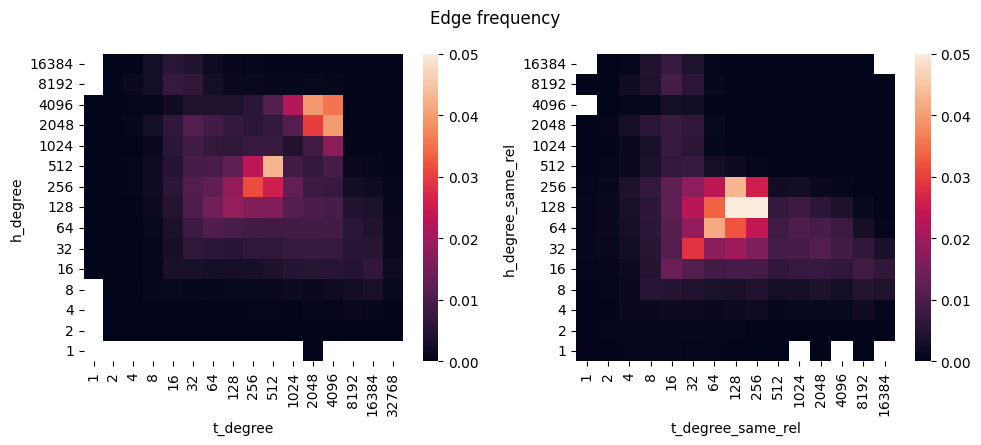

In [9]:
# Edge frequency when binning by head and tail degree

metrics = [("h_degree", "t_degree"), ("h_degree_same_rel", "t_degree_same_rel")]
fig, ax = plt.subplots(1, len(metrics), figsize=[5 * len(metrics), 4.5])

for i, (group_metric_1, group_metric_2) in enumerate(metrics):
    df_empty = pd.DataFrame(
        columns=np.int32(2 ** np.arange(15)), index=np.int32(2 ** np.arange(15))
    )
    df_tmp = edge_dcs[[group_metric_1, group_metric_2]]
    df_tmp.insert(
        0,
        f"log_{group_metric_1}",
        np.int32(2 ** np.floor(np.log2(df_tmp[group_metric_1]))),
    )
    df_tmp.insert(
        0,
        f"log_{group_metric_2}",
        np.int32(2 ** np.floor(np.log2(df_tmp[group_metric_2]))),
    )
    df_tmp = (
        df_tmp.groupby([f"log_{group_metric_1}", f"log_{group_metric_2}"])
        .count()
        .reset_index()
    )
    df_tmp[group_metric_1] /= df_tmp[group_metric_1].sum()
    sns.heatmap(
        df_tmp.reset_index()
        .pivot(
            columns=f"log_{group_metric_2}",
            index=f"log_{group_metric_1}",
            values=group_metric_1,
        )
        .combine_first(df_empty),
        annot=False,
        vmin=0,
        vmax=0.05,
        ax=ax[i],
    )
    ax[i].set_xlabel(group_metric_2)
    ax[i].set_ylabel(group_metric_1)
    ax[i].invert_yaxis()
fig.suptitle("Edge frequency")
plt.tight_layout()

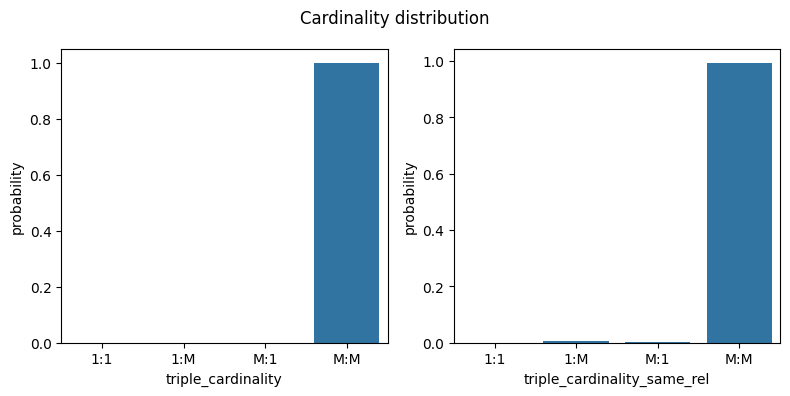

In [10]:
metrics = ["triple_cardinality", "triple_cardinality_same_rel"]
fig, ax = plt.subplots(1, len(metrics), figsize=[4 * len(metrics), 4])

for i, metric in enumerate(metrics):
    sns.countplot(
        x=edge_dcs[metric],
        order=["1:1", "1:M", "M:1", "M:M"],
        stat="probability",
        ax=ax[i],
    )
fig.suptitle("Cardinality distribution")
plt.tight_layout()

### Edge topological patterns

`KGTopologyToolbox` also allows us to perform a topological analysis at the edge level, using the method `edge_pattern_summary`, which extracts information on several significant edge topological patterns. In particular, it detects whether the edge (h,r,t) is a loop, is symmetric or has inverse, inference, composition (directed and undirected):

![image info](../images/edge_patterns.png)

For inverse/inference, the method also provides the number and types of unique relations `r'` realizing the counterpart edges; for composition, the number of triangles supported by the edge is provided (the unique metapaths `[r_1, r_2]` can also be listed by setting `return_metapath_list=True` when calling the method).

In [11]:
edge_eps = kgtt.edge_pattern_summary()
edge_eps

,h,r,t,is_loop,is_symmetric,has_inverse,n_inverse_relations,inverse_edge_types,has_inference,n_inference_relations,inference_edge_types,has_composition,has_undirected_composition,n_triangles,n_undirected_triangles
0,1718,0,3207,False,False,False,0,[],False,0,[0],False,True,0,15
1,4903,0,13662,False,False,False,0,[],False,0,[0],True,True,44,153
2,5480,0,15999,False,False,False,0,[],False,0,[0],False,True,0,1
3,3148,0,7247,False,False,False,0,[],False,0,[0],True,True,10,29
4,10300,0,16202,False,False,False,0,[],False,0,[0],True,True,3,79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5088429,2451,50,5097,False,False,True,1,[46],True,1,"[46, 50]",True,True,1532,5722
5088430,6456,50,8833,False,False,True,2,"[45, 46]",True,2,"[45, 46, 50]",True,True,234,913
5088431,9484,50,15873,False,False,True,1,[46],True,2,"[46, 45, 50]",True,True,1326,5004
5088432,6365,50,496,False,False,True,2,"[45, 46]",True,2,"[45, 46, 50]",True,True,1433,5554


In [12]:
print("Fraction of triples with property:")
edge_eps[
    ["is_loop", "is_symmetric", "has_inverse", "has_inference", "has_composition"]
].mean()

Fraction of triples with property:


is_loop            0.000011
is_symmetric       0.713743
has_inverse        0.409704
has_inference      0.410111
has_composition    0.997605
dtype: float64

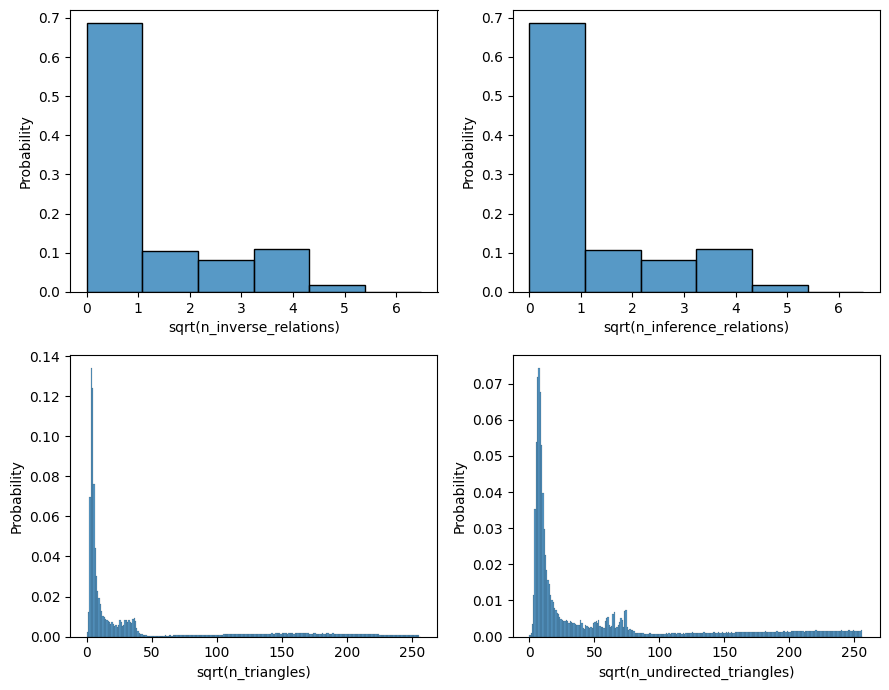

In [13]:
metrics = [
    "n_inverse_relations",
    "n_inference_relations",
    "n_triangles",
    "n_undirected_triangles",
]
fig, ax = plt.subplots(2, 2, figsize=(9, 7))

for axn, metric in zip(ax.flatten(), metrics):
    x = np.sqrt(edge_eps[metric])
    sns.histplot(x=x, stat="probability", binwidth=1, binrange=[0, x.max() + 1], ax=axn)
    axn.set_xlabel(f"sqrt({metric})")
plt.tight_layout()

## Relation-level analysis

All edge topological properties seen in the previous section can be aggregated over triples of the same relation type, to produce relation-level statistics. To do so, we can either set the option `aggregate_by_r = True` when calling the methods `edge_degree_cardinality_summary`, `edge_pattern_summary`, or - if edge topological metrics have already been precomputed - use the utility function `aggregate_by_relation`, which converts DataFrames indexed on the KG edges to DataFrames indexed on the IDs of the unique relation types.

In [15]:
from kg_topology_toolbox.utils import aggregate_by_relation

aggregate_by_relation(edge_dcs).head()

,num_triples,frac_triples,unique_h,unique_t,h_degree_mean,h_degree_std,h_degree_quartile1,h_degree_quartile2,h_degree_quartile3,h_unique_rel_mean,...,tot_degree_same_rel_quartile1,tot_degree_same_rel_quartile2,tot_degree_same_rel_quartile3,triple_cardinality_1:M_frac,triple_cardinality_M:1_frac,triple_cardinality_M:M_frac,triple_cardinality_same_rel_1:1_frac,triple_cardinality_same_rel_1:M_frac,triple_cardinality_same_rel_M:1_frac,triple_cardinality_same_rel_M:M_frac
r,,,,,,,,,,,,,,,,,,,,,
0,81066,0.015931,9742,9337,569.252202,1083.315332,111.0,222.0,521.0,8.110293,...,45.0,112.0,211.0,0.0,0.0,1.0,0.001628,0.023586,0.064959,0.909827
1,5669,0.001114,698,1536,2518.765391,2186.452620,435.0,2087.0,4028.0,27.048157,...,14.0,32.0,60.0,0.0,0.0,1.0,0.002822,0.104251,0.027518,0.865408
2,66954,0.013158,612,612,4129.511919,1935.630599,2548.0,3968.0,5649.0,36.404307,...,332.0,404.0,482.0,0.0,0.0,1.0,0.000000,0.000254,0.000239,0.999507
3,19585,0.003849,491,491,4527.399592,1943.714179,2925.0,4507.0,6161.0,37.095941,...,114.0,157.0,202.0,0.0,0.0,1.0,0.000000,0.000868,0.000970,0.998162
4,32034,0.006295,526,525,4511.067834,1905.395180,2931.0,4507.0,6148.0,37.319567,...,188.0,243.0,299.0,0.0,0.0,1.0,0.000062,0.000531,0.000593,0.998814


Notice on the extra columns `num_triples`, `frac_triples`, `unique_h`, `unique_t` giving additional statistics for relation types (number of edges and relative frequency, number of unique entities used as heads/tails by triples of the relation type).

Similarly, by aggregating the `edge_eps` DataFrame we can look at the distribution of edge topological patterns within each relation type.

In [16]:
aggregate_by_relation(edge_eps).head()

,num_triples,frac_triples,unique_h,unique_t,is_loop_frac,is_symmetric_frac,has_inverse_frac,n_inverse_relations_mean,n_inverse_relations_std,n_inverse_relations_quartile1,...,n_triangles_mean,n_triangles_std,n_triangles_quartile1,n_triangles_quartile2,n_triangles_quartile3,n_undirected_triangles_mean,n_undirected_triangles_std,n_undirected_triangles_quartile1,n_undirected_triangles_quartile2,n_undirected_triangles_quartile3
r,,,,,,,,,,,,,,,,,,,,,
0,81066,0.015931,9742,9337,0.000012,0.000222,0.009474,0.018762,0.336120,0.0,...,49.615572,816.776738,3.0,7.0,16.00,136.452841,1421.830008,18.00,36.0,68.0
1,5669,0.001114,698,1536,0.000000,0.000353,0.061563,0.527783,2.502323,0.0,...,1630.912154,6563.522736,13.0,84.0,234.00,2864.104428,9520.116812,54.00,224.0,586.0
2,66954,0.013158,612,612,0.000000,0.947367,0.998253,11.019118,4.707246,8.0,...,27666.694925,15797.649746,14990.0,25934.0,38868.50,32678.993563,18619.016056,16691.00,32647.5,48637.0
3,19585,0.003849,491,491,0.000000,0.947358,0.999592,13.417258,4.585150,10.0,...,30250.858974,17053.925410,16204.0,28873.0,43798.00,32696.125351,18685.281686,16563.00,32808.0,48653.0
4,32034,0.006295,526,525,0.000000,0.947368,0.999376,13.299588,4.427898,10.0,...,30942.231192,16888.956656,17303.0,30137.5,44161.25,32685.210464,18685.267154,16645.25,32580.0,48767.0


Additional methods are provided in the `KGTopologyToolbox` class for analysis at the relation level: `jaccard_similarity_relation_sets` to compute the Jaccard similarity of the sets of head/tail entities used by each relation; `relational_affinity_ingram` to compute the InGram pairwise relation similarity (see [paper](https://arxiv.org/abs/2305.19987)). 

In [17]:
kgtt.jaccard_similarity_relation_sets()

,r1,r2,num_triples_both,frac_triples_both,num_entities_both,num_h_r1,num_h_r2,num_t_r1,num_t_r2,jaccard_head_head,jaccard_head_tail,jaccard_tail_head,jaccard_tail_tail,jaccard_both
1,0,1,86735,0.017046,14338,9742,698,9337,1536,0.064112,0.055301,0.037317,0.079635,0.112289
2,0,2,148020,0.029089,13934,9742,612,9337,612,0.056531,0.056531,0.031947,0.031947,0.041768
3,0,3,100651,0.019780,13929,9742,491,9337,491,0.045037,0.045037,0.026530,0.026530,0.033527
4,0,4,113100,0.022227,13931,9742,526,9337,525,0.048290,0.048188,0.027610,0.027506,0.035819
5,0,5,132276,0.025995,13931,9742,576,9337,578,0.053287,0.053491,0.029815,0.029916,0.039624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2446,47,49,18021,0.003542,2414,806,1885,809,1886,0.131148,0.131568,0.132409,0.132353,0.135874
2447,47,50,374193,0.073538,5592,806,5224,809,5228,0.082391,0.082526,0.083318,0.083453,0.084764
2497,48,49,43122,0.008475,3407,2728,1885,2729,1886,0.371284,0.369952,0.371989,0.371064,0.370707
2498,48,50,399294,0.078471,6201,2728,5224,2729,5228,0.287356,0.287379,0.286061,0.286084,0.289147


In [18]:
kgtt.relational_affinity_ingram()

,h_relation,t_relation,edge_weight
0,0,1,5.565931
1,0,2,0.244410
2,0,3,0.049564
3,0,4,0.079068
4,0,5,0.159787
...,...,...,...
2545,50,45,393.082900
2546,50,46,421.818843
2547,50,47,1.194898
2548,50,48,18.124874
